In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits
import os
import math
import random
from scipy import special, integrate

In [2]:
data = fits.open('../OP-2/data/Lightcurves/gen_20221104.lc')
data[1].data['TIME']


array([1.84291205e+08, 1.84291215e+08, 1.84291225e+08, ...,
       1.84377575e+08, 1.84377585e+08, 1.84377595e+08])

In [22]:
def getFlareInfo(flare):
    flaredate = flare[0]
    starttime = flare[1]
    endtime = flare[5]
    Aprime = flare[15]
    mu = flare[16]
    sigma = flare[17]
    tau = flare[18]
    return flaredate, starttime, endtime, Aprime, mu, sigma, tau

def getFlareTime(catalog):
    alltime = []
    cat = np.loadtxt(catalog, dtype='str',skiprows=1,delimiter=',')
    for i in range(len(cat)):
        flaredate, startime, endtime, Aprime, mu, sigma, tau= getFlareInfo(cat[i])
        flaredate = flaredate.astype(int)
        startime = startime.astype(int)
        endtime = endtime.astype(int)
        Aprime = Aprime.astype(float)
        mu = mu.astype(float)
        sigma = sigma.astype(float)
        tau = tau.astype(float)
        alltime.append([flaredate,startime,endtime, Aprime, mu, sigma, tau])
    return alltime

In [23]:
timings = getFlareTime('Data/SD-CH2.csv')

In [24]:
def getFlux():
    flare =[]
    allflux = []
    alltime = []
    datafolder = '../OP-2/data/Lightcurves/'

    for filename in os.listdir(datafolder):
        for i in timings:
            
            if filename.endswith('.lc'):
                file_date = filename.split('_')[1]
                file_date = file_date.split('.')[0]

                if str(i[0]) == str(file_date):
                    starttime = i[1]
                    endtime = i[2]

                    data = fits.open(datafolder+filename)
                    time = data[1].data['TIME']
                    flux = data[1].data['FLUX']
                    startindex = None
                    endindex = None
                    for j in range(len(time)):
                        if time[j] == starttime:
                            startindex = j
                        if time[j] == endtime:
                            endindex = j

                    flare_time = time[startindex:endindex]
                    flare_flux = flux[startindex:endindex]

                    flare.append(i)
                    allflux.append(flare_flux)
                    alltime.append(flare_time)
                    
    return flare, allflux, alltime


In [25]:
AllFlares = getFlux()

[[2.0221019e+07 8.4945000e+04 8.5725000e+04 ... 8.5010680e+04
  4.4370000e+01 2.7021000e+02]
 [2.0221019e+07 8.4515000e+04 8.5025000e+04 ... 8.4743040e+04
  1.1619000e+02 2.7920000e+01]
 [2.0221019e+07 8.0215000e+04 8.3215000e+04 ... 8.2525880e+04
  3.3413000e+02 5.6580000e+01]
 ...
 [2.0220821e+07 1.7705000e+04 2.1145000e+04 ... 1.7787030e+04
  5.6910000e+01 1.0520900e+03]
 [2.0220821e+07 1.1515000e+04 1.1965000e+04 ... 1.1656650e+04
  1.0967000e+02 6.7997200e+03]
 [2.0220821e+07 1.0855000e+04 1.1855000e+04 ... 1.1315750e+04
  2.3120000e+02 3.8870000e+01]]


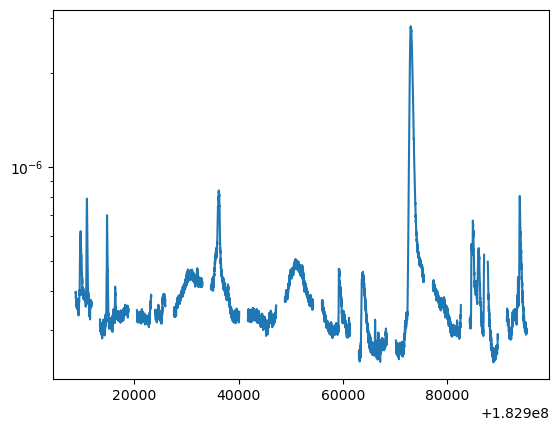

In [81]:
allflare, allflux, alltime = AllFlares

allflare = np.array(allflare)
alltime = np.array(alltime)
allflux = np.array(allflux)

print(allflare)
# print(alltime)
# print(allflux)

plt.plot(alltime[0],allflux[0])
# plt.xscale('log')
plt.yscale('log')
plt.show()

In [98]:
def EFP(x,A,mu,sigma,tau):
    return A * np.exp((0.5 * (sigma/tau)**2) - ((x-mu)/tau)) \
        * special.erfc( (1/np.sqrt(2)) * ( (sigma/tau) - ((x-mu) / sigma) ) )

In [95]:
print(EFP(84945 ,326.02 ,85010.68 ,44.37 ,270.21))

421.3697340028121


In [175]:
allfit_fluxntime = []
for i in allflare:
    date, startime, endtime, A, mu, sigma, tau = i
    x = np.linspace(startime,endtime,1000)
    fit_flux = EFP(x,A,mu,sigma,tau)
    allfit_fluxntime.append([date,i,x,fit_flux])


/tmp/ipykernel_94609/3382453297.py:3: RuntimeWarning: divide by zero encountered in divide
  * special.erfc( (1/np.sqrt(2)) * ( (sigma/tau) - ((x-mu) / sigma) ) )
/tmp/ipykernel_94609/3382453297.py:3: RuntimeWarning: invalid value encountered in divide
  * special.erfc( (1/np.sqrt(2)) * ( (sigma/tau) - ((x-mu) / sigma) ) )


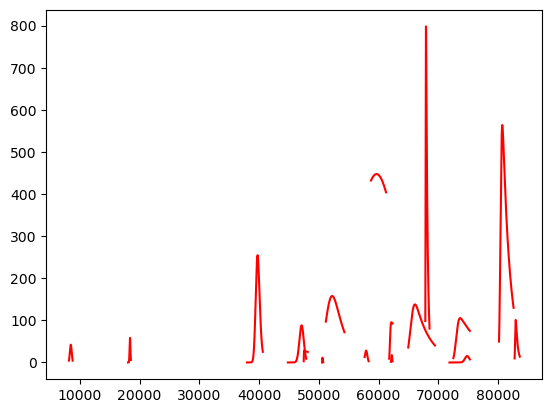

In [177]:
for i in allfit_fluxntime:
    if i[0] == 20221104:
        flux = i[3]
        # flux = flux[flux> 0.1]
        time = i[2]
        # time = time[flux > 0.1]
        plt.plot(time,flux,color='r')
# plt.yscale('log')
plt.show()

In [178]:
allflare_fluence = []
for i in allfit_fluxntime:
    date = i[0]
    date, startime, endtime, A, mu, sigma, tau = i[1]
    time = i[2]
    flux = i[3]
    
    area, error = integrate.quad(EFP, time[0], time[-1], args=(A,mu,sigma,tau))
    fluence = area
    allflare_fluence.append([date,time,fluence,error])

/tmp/ipykernel_94609/3382453297.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  * special.erfc( (1/np.sqrt(2)) * ( (sigma/tau) - ((x-mu) / sigma) ) )


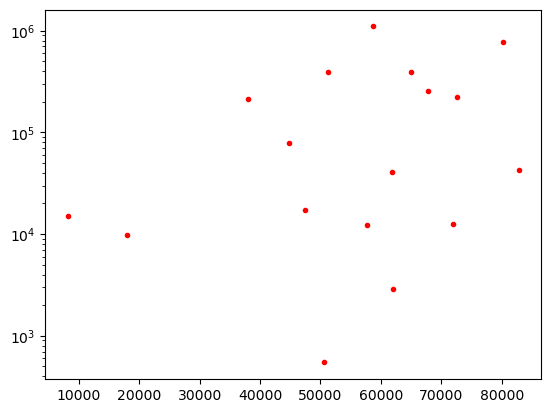

6722.422040834078 1.4860341201814981e-08


In [190]:
lol = 100
for i in allflare_fluence:
    if i[0] == 20221104:
        fluence = i[2]
        
        # flux = flux[flux> 0.1]
        time = i[1]
        error = i[3]
        # time = time[flux > 0.1]
        plt.plot(time[0],fluence,'.',color='r')
        
plt.yscale('log')
plt.show()
print(allflare_fluence[lol][2],allflare_fluence[lol][3])

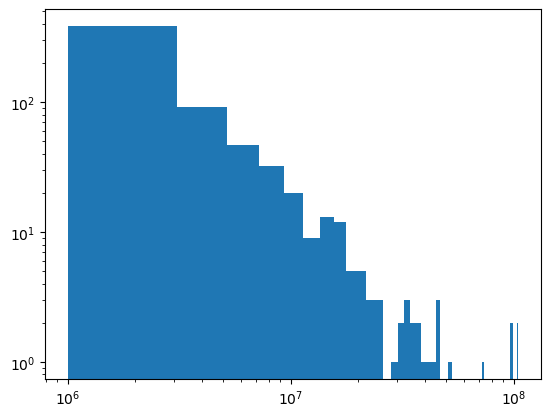

In [191]:
fluence =[]

with open('Data/fluence.txt', 'w') as f:
    pass  # This creates an empty file

for i in allflare_fluence:
    # write to a file
    with open('Data/fluence.txt', 'a') as f:  # 'a' opens the file in append mode
        f.write(str(i[2]) + '\n')  # Add a newline to separate values
    fluence.append(i[2])

fluence = np.array(fluence)
fluence = fluence[(fluence > 1e6)]
plt.hist(fluence,bins=50)
plt.yscale('log')
plt.xscale('log')
plt.show()